#  🤗 Transformers

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://huggingface.co/docs/transformers/index
* https://huggingface.co/docs/transformers/main_classes/pipelines#transformers.pipeline.task
* https://huggingface.co/docs/transformers/preprocessing
* https://habr.com/ru/articles/704592/
* https://lightning.ai/docs/torchmetrics/stable/text/bleu_score.html

## Задачи для совместного разбора

1\. Обсудите основные возможности и экосистему пакета 🤗 Transformers на примере задачи поиска ответа на вопрос в тексте.

In [1]:
text = """The seminars on Deep Learning and Natural Language Processing were truly captivating,
providing a deep dive into the intricacies of these disciplines.
The wealth of knowledge and insights gained during the sessions was commendable.
However, it's disheartening to note the scarcity of homework assignments.
Anastasia, in particular, is quite concerned that the limited number of assignments might
fall short of even reaching 30. While the seminars were intellectually stimulating,
the desire for more hands-on practice through assignments remains strong,
as it is crucial for reinforcing the theoretical understanding acquired during the classes."""

In [2]:
question1 = "What would be the ideal number of homework assignments for Anastasia"
question2 = "What are the shortcomings of the course?"

## Задачи для самостоятельного решения

In [3]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, pipeline
from torchmetrics.text import BLEUScore
import json
import torch
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
import requests
from PIL import Image
from IPython.display import Audio, display
import scipy.io.wavfile
import numpy as np
import librosa

<p class="task" id="1"></p>

1\. Среди предобученных моделей найдите модель для перевода текста с русского языка на английский. Протестируйте данную модель на нескольких предложениях, используя `transformers.pipeline`. Выведите результаты работы в следующем виде:

```
sentence1_ru -> sentence1_en
sentence2_ru -> sentence2_en
```

Получите перевод для всех текстов из файла `RuBQ_2.0_test.json` и посчитайте BLEU-score.

- [ ] Проверено на семинаре

In [4]:
translator = pipeline("translation", model="facebook/nllb-200-distilled-600M")

test_sentences = [
    "Машинное обучение это увлекательно.",
    "Как пройти в библиотеку?",
    "Я изучаю библиотеку Transformers."
]



translations = translator(test_sentences, src_lang='russian', tgt_lang='english')

for original, translated in zip(test_sentences, translations):
    print(f"{original} -> {translated['translation_text']}")


Device set to use cuda:0


Машинное обучение это увлекательно. -> Machine learning is exciting.
Как пройти в библиотеку? ->  How do you get to the library?
Я изучаю библиотеку Transformers. -> I am studying the Transformers library.


In [5]:
with open('C:\Projects\FU\Course_3\DL\RuBQ_2.0_test.json', encoding='utf-8') as f:
    rubq_data = json.load(f)

source_texts = [item['question_text'] for item in rubq_data]
target_texts = [item['question_eng'] for item in rubq_data]

print(f"Всего загружено примеров: {len(source_texts)}")
print(f"Пример пары: {source_texts[0]} -> {target_texts[0]}")

Всего загружено примеров: 580
Пример пары: Какой стране принадлежит знаменитый остров Пасхи? -> Which country does the famous Easter island belong to?


<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Rog G16\AppData\Local\Temp\ipykernel_27812\1871273485.py:1: SyntaxWarning: invalid escape sequence '\P'
  with open('C:\Projects\FU\Course_3\DL\RuBQ_2.0_test.json', encoding='utf-8') as f:


In [6]:
generated_translations = translator(source_texts, src_lang='russian', tgt_lang='english')

preds = [res['translation_text'] for res in generated_translations]
metric = BLEUScore()
targets_formatted = [[t] for t in target_texts]
score = metric(preds, targets_formatted)

print(f"BLEU Score: {score.item():.4f}")

BLEU Score: 0.3714


<p class="task" id="2"></p>

2\. Среди предобученных моделей найдите модель для классификации фотографий людей по полу.

Протестируйте данную модель на нескольких фотографиях, используя `AutoFeatureExtractor` и `AutoModelForImageClassification`.

Выведите на экран сетку 2х2 из изображений, где над каждым изображением добавлена подпись, содержащая прогноз модели и правильный ответ.

- [ ] Проверено на семинаре

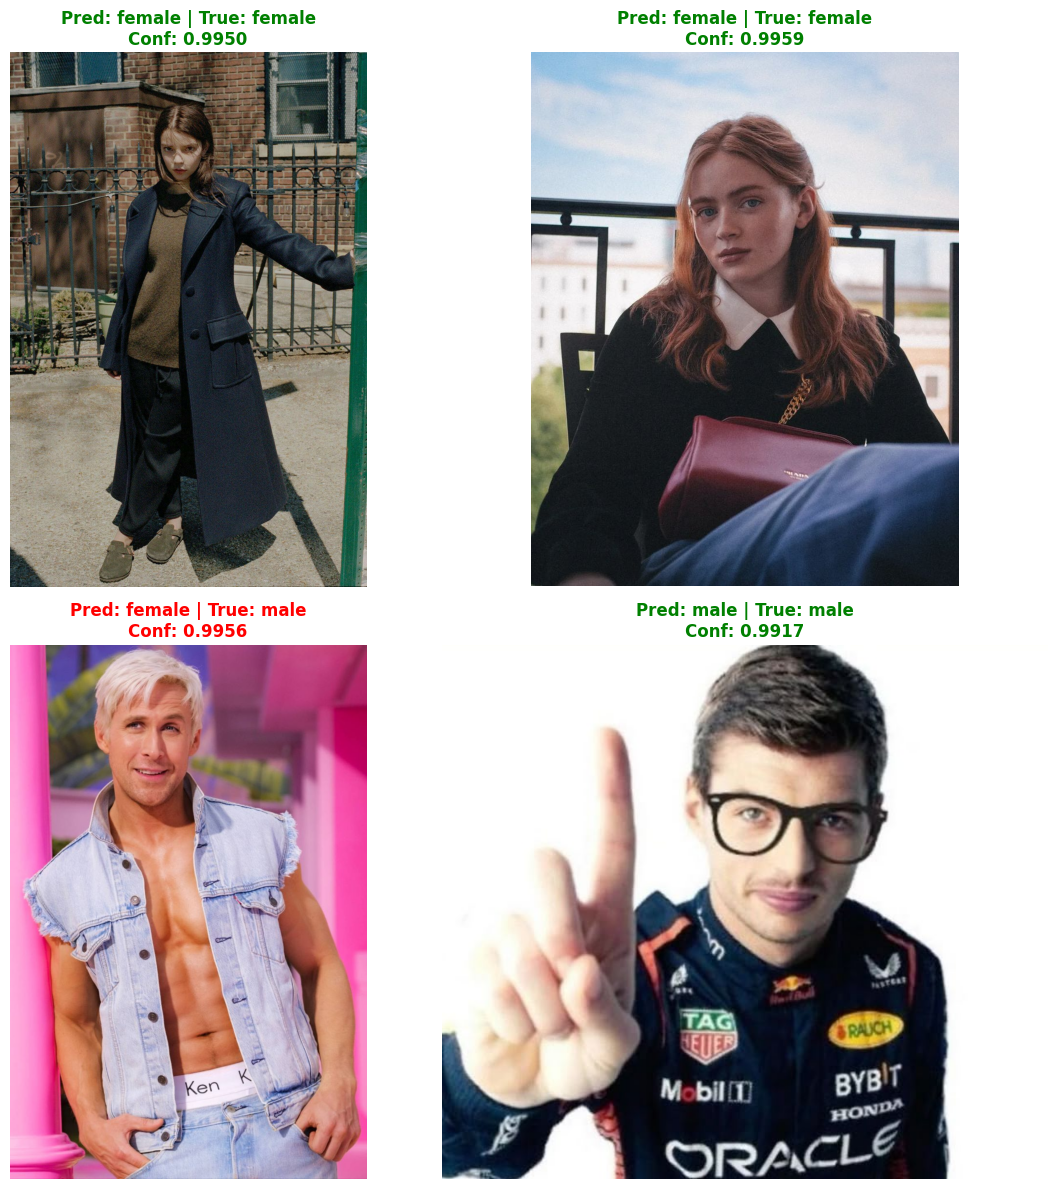

In [27]:
model_name = "rizvandwiki/gender-classification-2"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name)

folder_path = "people"


image_files = sorted([
    f for f in os.listdir(folder_path) 
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])[:4]


ground_truths = ["female", "female", "male", "male", "male", "male"][:len(image_files)]

fig, axes = plt.subplots(2,2, figsize=(12, 12))
axes = axes.flatten()

for i, filename in enumerate(image_files):
    img_path = os.path.join(folder_path, filename)
    image = Image.open(img_path).convert("RGB")
    
    inputs = feature_extractor(images=image, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**inputs)
        
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    predicted_label = model.config.id2label[predicted_class_idx]
    true_label = ground_truths[i]
    is_correct = predicted_label.lower() == true_label.lower()
    title_color = "green" if is_correct else "red"
    
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(
        f"Pred: {predicted_label} | True: {true_label}\nConf: {logits.softmax(1).squeeze()[predicted_class_idx].numpy():.4f}", 
        color=title_color, 
        fontweight="bold", 
        fontsize=12
    )

plt.tight_layout()
plt.show()

<p class="task" id="3"></p>

3\. Среди предобученных моделей найдите модель для генерации аудио по тексту. Используя [данный сервис](https://geek-jokes.sameerkumar.website/api?format=json), получите текст случайной шутки. Сгенерируйте аудио с озвучкой данной шутки.

Для прослушивания полученного аудио воспользуйтесь встроенным виджетом `IPython.display.Audio`

- [ ] Проверено на семинаре

In [8]:
def get_random_joke():
    url = "https://geek-jokes.sameerkumar.website/api?format=json"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        return data['joke']
    except Exception as e:
        return f"Error fetching joke: {e}"

joke_text = get_random_joke()
print(f"Текст шутки:\n{joke_text}")

synthesiser = pipeline("text-to-speech", model="suno/bark-small")

speech = synthesiser(joke_text)

audio_data = speech["audio"]
sampling_rate = speech["sampling_rate"]
Audio(audio_data.squeeze(), rate=sampling_rate)

Текст шутки:
Chuck Norris's first program was kill -9.


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/353 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


<p class="task" id="4"></p>

4\. Разработайте решение для поиска ответа на голосовой вопрос по тексту, используя готовые модели `transformers`. Решение должно включать себя следующие модели:
- модель распознавания текста из аудио;
- модель поиска ответа на вопрос в тексте;
- модель генерации аудио по тексту.

В качестве входных данных запишите небольшой аудиофрагмент в формате на русском языке. Для записи вы можете воспользоваться любым устройством: мобильным телефоном, веб-приложением (например, [этим](https://vocalremover.org/ru/voice-recorder)) и т.д.

В качестве контекста для поиска ответа используйте предложенный текст.

Продемонстируйте все промежуточные результаты, полученные в процессе работы конвейера моделей.

- [ ] Проверено на семинаре

In [9]:
text = """
Машинное обучение — это раздел искусственного интеллекта, который позволяет компьютерным системам улучшать свою работу на основе опыта без явного программирования.
Основная идея заключается в том, что алгоритмы могут учиться на данных, выявляя закономерности и принимая решения с минимальным вмешательством человека.
Существует несколько типов машинного обучения: обучение с учителем, где алгоритм учится на размеченных данных; обучение без учителя, работающее с неразмеченными данными;
и обучение с подкреплением, где алгоритм учится через взаимодействие с окружающей средой.
"""

question_text_initial = "Какие существуют типы машинного обучения?"
device = "cuda:0" if torch.cuda.is_available() else "cpu"
pre_tts = pipeline("text-to-speech", model="facebook/mms-tts-rus", device=device)
question_audio_data = pre_tts(question_text_initial)

audio_filename = "input_question.wav"
scipy.io.wavfile.write(
    audio_filename,
    rate=question_audio_data["sampling_rate"],
    data=question_audio_data["audio"].squeeze()
)

print(f"Файл '{audio_filename}' создан.")

audio_array, sampling_rate = librosa.load(audio_filename, sr=16000)

asr_pipeline = pipeline("automatic-speech-recognition", model="openai/whisper-large-v3", device=device)
asr_result = asr_pipeline(audio_array, generate_kwargs={"language": "russian"})
recognized_text = asr_result['text']

print(f"Распознанный текст: {recognized_text}")


qa_pipeline = pipeline("question-answering", model="timpal0l/mdeberta-v3-base-squad2", device=device)

qa_result = qa_pipeline(question=recognized_text, context=text)
answer_text = qa_result['answer']

print(f"Найденный ответ: {answer_text}")
print(f"Уверенность модели (score): {qa_result['score']:.4f}")

tts_result = pre_tts(answer_text)
print("\n✅ ИТОГОВЫЙ АУДИО-ОТВЕТ:")
Audio(tts_result["audio"].squeeze(), rate=tts_result["sampling_rate"])

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/145M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/511 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Device set to use cuda:0


Файл 'input_question.wav' создан.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

Device set to use cuda:0
`return_token_timestamps` is deprecated for WhisperFeatureExtractor and will be removed in Transformers v5. Use `return_attention_mask` instead, as the number of frames can be inferred from it.


Распознанный текст:  Какие существуют типы машинного обучения?


config.json:   0%|          | 0.00/879 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Device set to use cuda:0


Найденный ответ:  обучение с учителем,
Уверенность модели (score): 0.0363

✅ ИТОГОВЫЙ АУДИО-ОТВЕТ:


# Очищаем душу

Ибо не положено на Руси кэш моделей окаянных на дисках славянских держать

In [ ]:
import shutil
import os
from pathlib import Path

home = Path.home()
hf_cache_dir = home / ".cache" / "huggingface"

def clean_hf_cache():
    if not hf_cache_dir.exists():
        print(f"Папка кэша не найдена по пути: {hf_cache_dir}")
        return

    print(f"Найден кэш Hugging Face: {hf_cache_dir}")
    
    confirm = input("Вы уверены, что хотите удалить ВСЕ модели и датасеты? (y/n): ")
    if confirm.lower() != 'y':
        print("Отмена.")
        return

    try:
        shutil.rmtree(hf_cache_dir)
        print("✅ Кэш успешно очищен! Все модели удалены.")
    except Exception as e:
        print(f"❌ Ошибка при удалении: {e}")
        print("Попробуйте закрыть все ноутбуки, использующие модели, и повторить.")

clean_hf_cache()

Найден кэш Hugging Face: C:\Users\Rog G16\.cache\huggingface
Отмена.
